In [103]:
import torch
torch.manual_seed(42)

class Net(torch.nn.Module):

    def __init__(self, indim=1, outdim=1):
        super().__init__()
        self.actf = torch.tanh
        self.lin1 = torch.nn.Linear(indim, 100)
        self.lin2 = torch.nn.Linear(100, outdim)

    def forward(self, x):
        x = self.lin1(x)
        x = self.lin2(self.actf(x))
        return x.squeeze()

In [104]:
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):

    def __init__(self, in_tensor, out_tensor):
        self.inp = in_tensor
        self.out = out_tensor

    def __len__(self):
        return len(self.inp)

    def __getitem__(self, idx):
        return self.inp[idx], self.out[idx]

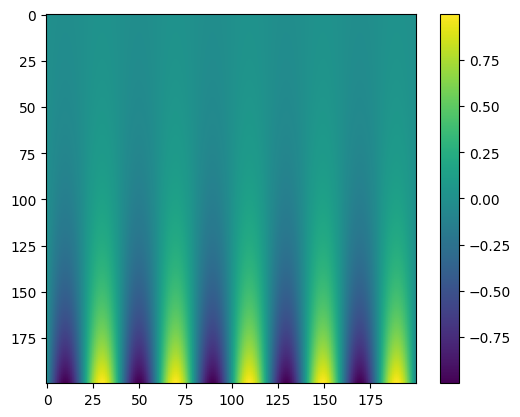

In [105]:
import numpy as np
import matplotlib.pyplot as plt

def u(x, t):
    return np.exp(-2*np.pi*np.pi*t)*np.sin(np.pi*x)

pts = 200
ts = np.linspace(0.2, 0, pts)
xs = np.linspace(-5, 5, pts)

X, T = np.meshgrid(xs, ts)
U = u(X, T)

plt.imshow(U)
plt.colorbar()

In [195]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_in = torch.tensor([[x, t] for x, t in zip(X.flatten(), T.flatten())], dtype=torch.float32, requires_grad=True)
train_out = torch.tensor(u(X.flatten(), T.flatten()), dtype=torch.float32)

train_in.to(DEVICE)
train_out.to(DEVICE)

train_dataset = MyDataset(train_in, train_out)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

def phys_loss(inp, out):
    dudt = torch.autograd.grad(out, inp, grad_outputs=torch.ones_like(out), create_graph=True, allow_unused=True)[0][:,[1]]
    dudx = torch.autograd.grad(out, inp, grad_outputs=torch.ones_like(out), create_graph=True, allow_unused=True)[0][:,[0]]
    d2udx2 = torch.autograd.grad(dudx, inp, grad_outputs=torch.ones_like(dudx), create_graph=True, allow_unused=True)[0][:,[0]]
    return torch.nn.MSELoss()(d2udx2, 0.5*dudt)

bdry_pts = 200
xs_bdry = np.linspace(-5, 5, bdry_pts)
ts_bdry = np.asarray([0 for x in xs_bdry])
us_bdry = u(xs_bdry, ts_bdry)

train_in_bd = torch.tensor([[x, t] for x, t in zip(xs_bdry, ts_bdry)], dtype=torch.float32, requires_grad=True)
train_out_bd = torch.tensor(us_bdry, dtype=torch.float32)

train_in_bd.to(DEVICE)
train_out_bd.to(DEVICE)

C:\Users\diade\AppData\Local\Temp\ipykernel_42336\2789383414.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_out = torch.tensor(u(X.flatten(), T.flatten()), dtype=torch.float32)


tensor([-6.1232e-16, -1.5721e-01, -3.1052e-01, -4.5610e-01, -5.9034e-01,
        -7.0989e-01, -8.1179e-01, -8.9350e-01, -9.5299e-01, -9.8877e-01,
        -9.9997e-01, -9.8629e-01, -9.4809e-01, -8.8630e-01, -8.0247e-01,
        -6.9869e-01, -5.7752e-01, -4.4199e-01, -2.9547e-01, -1.4160e-01,
         1.5786e-02,  1.7278e-01,  3.2549e-01,  4.7009e-01,  6.0301e-01,
         7.2092e-01,  8.2091e-01,  9.0048e-01,  9.5765e-01,  9.9101e-01,
         9.9972e-01,  9.8357e-01,  9.4295e-01,  8.7888e-01,  7.9295e-01,
         6.8730e-01,  5.6456e-01,  4.2778e-01,  2.8036e-01,  1.2596e-01,
        -3.1569e-02, -1.8831e-01, -3.4037e-01, -4.8397e-01, -6.1552e-01,
        -7.3177e-01, -8.2982e-01, -9.0723e-01, -9.6208e-01, -9.9300e-01,
        -9.9922e-01, -9.8059e-01, -9.3758e-01, -8.7124e-01, -7.8324e-01,
        -6.7575e-01, -5.5146e-01, -4.1346e-01, -2.6517e-01, -1.1028e-01,
         4.7343e-02,  2.0379e-01,  3.5517e-01,  4.9772e-01,  6.2789e-01,
         7.4244e-01,  8.3853e-01,  9.1376e-01,  9.6

In [196]:
from torch.optim import Adam, LBFGS
from torch.optim.lr_scheduler import LambdaLR
from torch.autograd import Variable

model = Net(indim=2, outdim=1).to(DEVICE)
epochs = 1000
optimizer = Adam(model.parameters(), lr=0.1)
scheduler = LambdaLR(optimizer=optimizer,
                     lr_lambda=lambda epoch: 0.999**epoch,
                     last_epoch=-1)

loss_fcn = torch.nn.MSELoss()

for epoch in range(0, epochs):
    for batch_in, batch_out in train_dataloader:
        batch_in = Variable(batch_in, requires_grad=True)
        batch_in.to(DEVICE)
        batch_out.to(DEVICE)
        model.train()
        def closure():
            optimizer.zero_grad()
            loss = loss_fcn(model(batch_in), batch_out)
            loss.backward()
            return loss
        optimizer.step(closure)
    #scheduler.step()
    model.eval()
    base = loss_fcn(model(train_in), train_out)
    phys = phys_loss(train_in, model(train_in))
    bdry = loss_fcn(model(train_in_bd), train_out_bd)
    epoch_loss = base + phys + bdry
    print(f'Epoch: {epoch+1} | Loss: {round(float(base), 4)} | {round(float(phys), 4)} | {round(float(bdry), 4)}')

Epoch: 1 | Loss: 0.0319 | 0.0058 | 0.4865
Epoch: 2 | Loss: 0.0321 | 0.0083 | 0.4862
Epoch: 3 | Loss: 0.0318 | 0.0118 | 0.4808
Epoch: 4 | Loss: 0.0412 | 0.0128 | 0.4904
Epoch: 5 | Loss: 0.0423 | 0.0133 | 0.4866
Epoch: 6 | Loss: 0.0347 | 0.0102 | 0.4807
Epoch: 7 | Loss: 0.0321 | 0.0132 | 0.4796
Epoch: 8 | Loss: 0.0309 | 0.016 | 0.4765
Epoch: 9 | Loss: 0.032 | 0.0299 | 0.4702
Epoch: 10 | Loss: 0.0325 | 0.0519 | 0.4713
Epoch: 11 | Loss: 0.033 | 0.1052 | 0.4656
Epoch: 12 | Loss: 0.0292 | 0.2181 | 0.4475
Epoch: 13 | Loss: 0.0344 | 0.3576 | 0.4345
Epoch: 14 | Loss: 0.0289 | 0.5431 | 0.416
Epoch: 15 | Loss: 0.0254 | 0.8003 | 0.3944
Epoch: 16 | Loss: 0.0269 | 0.9049 | 0.3881
Epoch: 17 | Loss: 0.0248 | 0.9702 | 0.3728
Epoch: 18 | Loss: 0.0227 | 1.0334 | 0.3573
Epoch: 19 | Loss: 0.0235 | 1.0963 | 0.3421
Epoch: 20 | Loss: 0.0234 | 1.1951 | 0.3356
Epoch: 21 | Loss: 0.0215 | 1.2503 | 0.3091
Epoch: 22 | Loss: 0.0224 | 1.2879 | 0.2955
Epoch: 23 | Loss: 0.0191 | 1.503 | 0.2765
Epoch: 24 | Loss: 0.0168 

KeyboardInterrupt: 

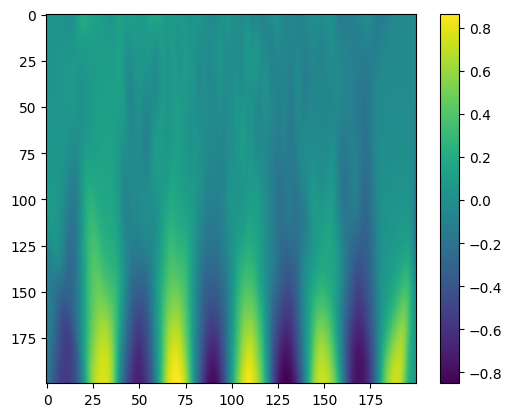

In [108]:
def u_model(xs, ts):
    pts = torch.tensor(np.array([[x, t] for x, t in zip(xs, ts)]), dtype=torch.float32)
    return model(pts)

pts = 200
ts = torch.linspace(0.2, 0, pts)
xs = torch.linspace(-5, 5, pts)
X, T = torch.meshgrid(xs, ts)
X = X.T
T = T.T

img = []
for x, t in zip(X, T):
    img.append(u_model(x, t).detach().numpy().tolist())

plt.imshow(img)
plt.colorbar()

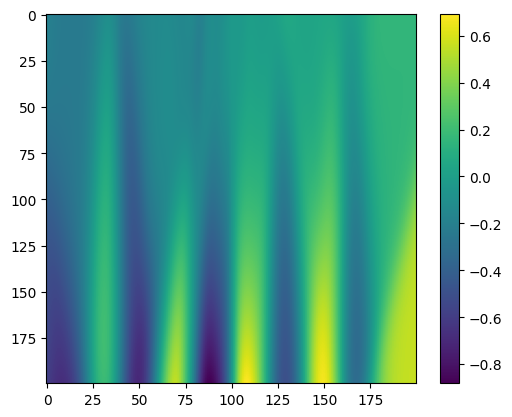

In [217]:
def u_model(xs, ts):
    pts = torch.tensor(np.array([[x, t] for x, t in zip(xs, ts)]), dtype=torch.float32)
    return model(pts)

pts = 200
ts = torch.linspace(0.2, 0, pts)
xs = torch.linspace(-5, 5, pts)
X, T = torch.meshgrid(xs, ts)
X = X.T
T = T.T

img = []
for x, t in zip(X, T):
    img.append(u_model(x, t).detach().numpy().tolist())

plt.imshow(img)
plt.colorbar()

In [111]:
model_pinn = Net(indim=2, outdim=1).to(DEVICE)
epochs = 1000
optimizer_pinn = Adam(model_pinn.parameters(), lr=0.1)
scheduler_pinn = LambdaLR(optimizer=optimizer_pinn,
                          lr_lambda=lambda epoch: 0.999**epoch,
                          last_epoch=-1)

loss_fcn = torch.nn.MSELoss()

for epoch in range(0, epochs):
    for batch_in, batch_out in train_dataloader:
        batch_in = Variable(batch_in, requires_grad=True)
        batch_in.to(DEVICE)
        batch_out.to(DEVICE)
        model_pinn.train()
        def closure():
            optimizer_pinn.zero_grad()
            loss = loss_fcn(model_pinn(batch_in), batch_out)
            loss += phys_loss(batch_in, model_pinn(batch_in))
            #loss += torch.sum(phys_loss(batch_in, model_pinn(batch_in)))/batch_in.shape[0]
            loss += loss_fcn(model_pinn(train_in_bd), train_out_bd)
            loss.backward()
            return loss
        optimizer_pinn.step(closure)
    #scheduler_pinn.step()
    model_pinn.eval()
    base = loss_fcn(model_pinn(train_in), train_out)
    phys = phys_loss(train_in, model_pinn(train_in))
    bdry = loss_fcn(model_pinn(train_in_bd), train_out_bd)
    epoch_loss = base + phys + bdry
    print(f'Epoch: {epoch+1} | Loss: {round(float(epoch_loss), 4)} = {round(float(base), 4)} + {round(float(phys), 4)} + {round(float(bdry), 4)}')

Epoch: 1 | Loss: 0.5396 = 0.0657 + 0.0006 + 0.4733
Epoch: 2 | Loss: 0.5446 = 0.0723 + 0.0007 + 0.4715
Epoch: 3 | Loss: 0.5351 = 0.0673 + 0.001 + 0.4668
Epoch: 4 | Loss: 0.5428 = 0.0765 + 0.0022 + 0.4642
Epoch: 5 | Loss: 0.522 = 0.065 + 0.0049 + 0.4521
Epoch: 6 | Loss: 0.5142 = 0.0613 + 0.0099 + 0.4429
Epoch: 7 | Loss: 0.5082 = 0.0667 + 0.0169 + 0.4245
Epoch: 8 | Loss: 0.516 = 0.0679 + 0.0244 + 0.4236
Epoch: 9 | Loss: 0.5087 = 0.0718 + 0.0235 + 0.4133
Epoch: 10 | Loss: 0.4831 = 0.0562 + 0.0244 + 0.4025
Epoch: 11 | Loss: 0.4803 = 0.0559 + 0.0448 + 0.3796
Epoch: 12 | Loss: 0.4386 = 0.0517 + 0.0691 + 0.3177
Epoch: 13 | Loss: 0.4396 = 0.0531 + 0.0785 + 0.308
Epoch: 14 | Loss: 0.4021 = 0.0468 + 0.074 + 0.2814
Epoch: 15 | Loss: 0.4274 = 0.048 + 0.0952 + 0.2842
Epoch: 16 | Loss: 0.4152 = 0.047 + 0.1126 + 0.2556
Epoch: 17 | Loss: 0.4693 = 0.046 + 0.1315 + 0.2918
Epoch: 18 | Loss: 0.3769 = 0.0472 + 0.1033 + 0.2265
Epoch: 19 | Loss: 0.4406 = 0.0462 + 0.1236 + 0.2708
Epoch: 20 | Loss: 0.3546 = 0.0

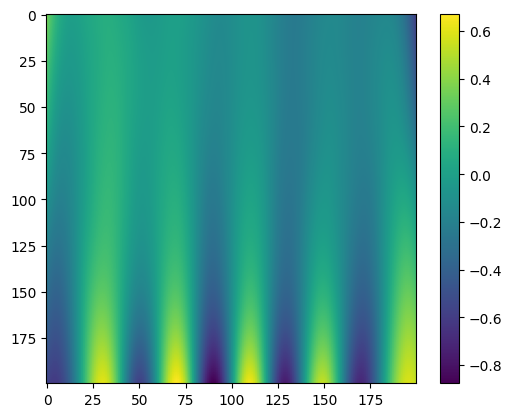

In [112]:
def u_model_pinn(xs, ts):
    pts = torch.tensor(np.array([[x, t] for x, t in zip(xs, ts)]), dtype=torch.float32)
    return model_pinn(pts)

pts = 200
ts = torch.linspace(0.2, 0, pts)
xs = torch.linspace(-5, 5, pts)
X, T = torch.meshgrid(xs, ts)
X = X.T
T = T.T

img = []
for x, t in zip(X, T):
    img.append(u_model_pinn(x, t).detach().numpy().tolist())

plt.imshow(img)
plt.colorbar()

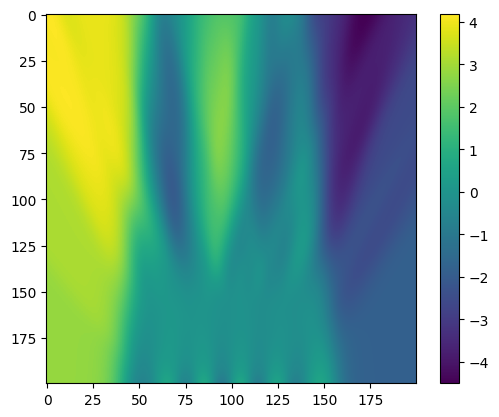

In [115]:
def u_model_pinn(xs, ts):
    pts = torch.tensor(np.array([[x, t] for x, t in zip(xs, ts)]), dtype=torch.float32)
    return model_pinn(pts)

pts = 200
ts = torch.linspace(1, 0, pts)
xs = torch.linspace(-10, 10, pts)
X, T = torch.meshgrid(xs, ts)
X = X.T
T = T.T

img = []
for x, t in zip(X, T):
    img.append(u_model_pinn(x, t).detach().numpy().tolist())

plt.imshow(img)
plt.colorbar()

In [123]:
from torch.optim import Adam, LBFGS

model_pinn_v2 = Net(indim=2, outdim=1).to(DEVICE)
epochs_adam = 100
epochs_lbfgs = 30
optimizer_pinn_adam = Adam(model_pinn_v2.parameters(), lr=0.1)
optimizer_pinn_lbfgs = LBFGS(model_pinn_v2.parameters(), lr=0.01)

loss_fcn = torch.nn.MSELoss()

for epoch in range(0, epochs_adam + epochs_lbfgs):
    current_optimizer = optimizer_pinn_adam if epoch <= epochs_adam else optimizer_pinn_lbfgs
    for batch_in, batch_out in train_dataloader:
        batch_in = Variable(batch_in, requires_grad=True)
        batch_in.to(DEVICE)
        batch_out.to(DEVICE)
        model_pinn_v2.train()
        def closure():
            current_optimizer.zero_grad()
            loss = loss_fcn(model_pinn_v2(batch_in), batch_out)
            loss += phys_loss(batch_in, model_pinn_v2(batch_in))
            loss += loss_fcn(model_pinn_v2(train_in_bd), train_out_bd)
            loss.backward()
            return loss
        current_optimizer.step(closure)
    model_pinn_v2.eval()
    base = loss_fcn(model_pinn_v2(train_in), train_out)
    phys = phys_loss(train_in, model_pinn_v2(train_in))
    bdry = loss_fcn(model_pinn_v2(train_in_bd), train_out_bd)
    epoch_loss = base + phys + bdry
    print(f'Epoch: {epoch+1} | Loss: {round(float(epoch_loss), 4)} = {round(float(base), 4)} + {round(float(phys), 4)} + {round(float(bdry), 4)}')

Epoch: 1 | Loss: 0.5404 = 0.0646 + 0.0003 + 0.4756
Epoch: 2 | Loss: 0.5517 = 0.0704 + 0.0009 + 0.4804
Epoch: 3 | Loss: 0.537 = 0.0652 + 0.0021 + 0.4697
Epoch: 4 | Loss: 0.6226 = 0.1089 + 0.0027 + 0.511
Epoch: 5 | Loss: 0.5334 = 0.0639 + 0.0021 + 0.4674
Epoch: 6 | Loss: 0.5796 = 0.0861 + 0.0023 + 0.4912
Epoch: 7 | Loss: 0.5353 = 0.0667 + 0.0033 + 0.4653
Epoch: 8 | Loss: 0.562 = 0.0788 + 0.005 + 0.4782
Epoch: 9 | Loss: 0.5296 = 0.0678 + 0.0065 + 0.4554
Epoch: 10 | Loss: 0.5534 = 0.0814 + 0.0106 + 0.4613
Epoch: 11 | Loss: 0.5273 = 0.072 + 0.0156 + 0.4397
Epoch: 12 | Loss: 0.5117 = 0.061 + 0.0182 + 0.4325
Epoch: 13 | Loss: 0.5113 = 0.0582 + 0.0164 + 0.4367
Epoch: 14 | Loss: 0.494 = 0.0547 + 0.0242 + 0.4152
Epoch: 15 | Loss: 0.493 = 0.0608 + 0.0273 + 0.4049
Epoch: 16 | Loss: 0.4897 = 0.0548 + 0.0408 + 0.3941
Epoch: 17 | Loss: 0.4795 = 0.0548 + 0.049 + 0.3757
Epoch: 18 | Loss: 0.4798 = 0.0518 + 0.059 + 0.369
Epoch: 19 | Loss: 0.5108 = 0.058 + 0.1053 + 0.3475
Epoch: 20 | Loss: 0.4249 = 0.0436

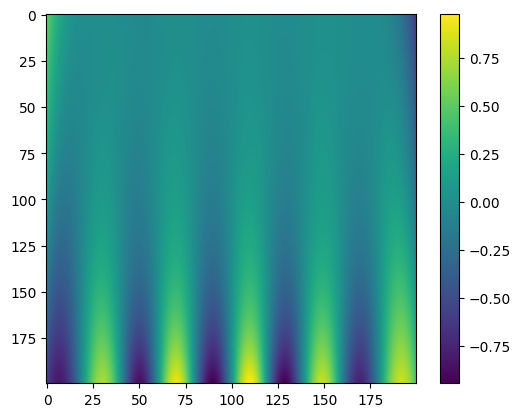

In [124]:
def u_model_pinn_v2(xs, ts):
    pts = torch.tensor(np.array([[x, t] for x, t in zip(xs, ts)]), dtype=torch.float32)
    return model_pinn_v2(pts)

pts = 200
ts = torch.linspace(0.2, 0, pts)
xs = torch.linspace(-5, 5, pts)
X, T = torch.meshgrid(xs, ts)
X = X.T
T = T.T

img = []
for x, t in zip(X, T):
    img.append(u_model_pinn_v2(x, t).detach().numpy().tolist())

plt.imshow(img)
plt.colorbar()

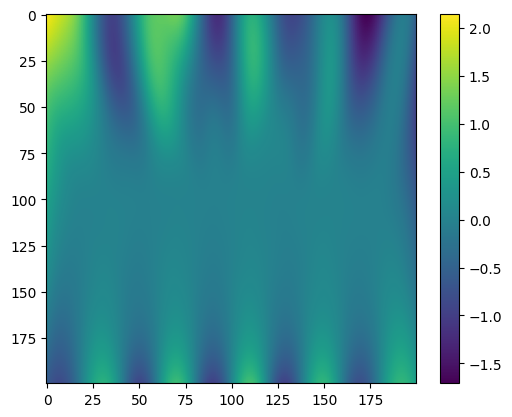

In [126]:
pts = 200
ts = torch.linspace(0.4, 0, pts)
xs = torch.linspace(-5, 5, pts)
X, T = torch.meshgrid(xs, ts)
X = X.T
T = T.T

img = []
for x, t in zip(X, T):
    img.append(u_model_pinn_v2(x, t).detach().numpy().tolist())

plt.imshow(img)
plt.colorbar()

In [271]:
from torch.func import jacrev, functional_call, vmap

torch.manual_seed(42)
model_vec = Net(indim=3, outdim=3).to(DEVICE)
params = dict(model_vec.named_parameters())

In [272]:
grad = torch.autograd.grad(model_vec(x), x, grad_outputs=torch.ones_like(model_vec(x)), create_graph=True, allow_unused=True)[0]
print(grad)

tensor([ 0.1809,  0.2170, -0.1783], grad_fn=<ViewBackward0>)


In [273]:
from torch.func import jacrev
jac = jacrev(model_vec)(x)
print(jac)

tensor([[-0.0622,  0.0219,  0.1662],
        [ 0.1229,  0.3468, -0.2792],
        [ 0.1202, -0.1517, -0.0654]], grad_fn=<ViewBackward0>)


In [266]:
from torch.func import jacrev, functional_call, vmap

torch.manual_seed(42)
model_vec = Net(indim=3, outdim=3).to(DEVICE)
params = dict(model_vec.named_parameters())

def func(params, x):
    return functional_call(model_vec, params, x)

x = torch.rand(2, 3)
x.requires_grad_()

print(x)

grad = torch.autograd.grad(model_vec(x), x, grad_outputs=torch.ones_like(model_vec(x)), create_graph=True, allow_unused=True)[0]
jac_vec = jacrev(func, argnums=(0))(params, x)

print(grad)
print(jac_vec)

tensor([[0.0806, 0.6256, 0.0947],
        [0.7112, 0.6579, 0.0656]], requires_grad=True)
tensor([[ 0.1809,  0.2170, -0.1783],
        [ 0.2145,  0.1772, -0.1988]], grad_fn=<MmBackward0>)
{'lin1.weight': tensor([[[[-0.0020, -0.0156, -0.0024],
          [ 0.0053,  0.0413,  0.0063],
          [ 0.0006,  0.0050,  0.0008],
          ...,
          [ 0.0067,  0.0521,  0.0079],
          [-0.0021, -0.0162, -0.0024],
          [-0.0029, -0.0225, -0.0034]],

         [[-0.0017, -0.0135, -0.0020],
          [-0.0038, -0.0296, -0.0045],
          [ 0.0014,  0.0106,  0.0016],
          ...,
          [-0.0064, -0.0493, -0.0075],
          [ 0.0056,  0.0436,  0.0066],
          [ 0.0008,  0.0062,  0.0009]],

         [[-0.0039, -0.0301, -0.0046],
          [ 0.0041,  0.0320,  0.0048],
          [-0.0076, -0.0591, -0.0090],
          ...,
          [ 0.0060,  0.0468,  0.0071],
          [-0.0045, -0.0349, -0.0053],
          [ 0.0063,  0.0489,  0.0074]]],


        [[[-0.0136, -0.0125, -0.0013],
   